In [1]:
import numpy as np
from scipy.optimize import *
import matplotlib.pyplot as plt
import math
import xlrd
import time

### Renewable

In [2]:
class RenewableGeneration:
    
    def __init__(self, t):
        self.t = t
    
    # power generation for one solar panel
    def solar_energy(self, G, Tc):
        # Solar Panel
        # PV module: SunPower SPR-230-WHT
        # Type of cell: Mono-c-Si

        # PV module coefficients
        Isc_ref = 5.99        # Short circuit current at SRC (standard rating condition) [A]
        Voc_ref = 48.7        # Open circuit voltage at SRC [V]
        Imp_ref = 5.61        # Current at maximum power point [A]
        Vmp_ref = 41          # Voltage at maximum power point [V]
        alpha_sc = 0.002132   # Temperature coefficient for short circuit current [A/K]
        a_ref = 1.9136        # ideality factor parameter at SRC [eV]
        Il_ref = 5.995        # Light current at SRC [A]
        Io_ref = 5.194e-11    # Diode reverse saturation current at SRC [A]
        Rs_ref = 0.321        # Series resistance at SRC [Ohm]
        Rsh_ref = 367.11      # Shunt resistance at SRC [Ohm]
        Tc_ref = 25 + 273.15  # Cell temperature at SRC [K]
        G_ref = 1000          # Radiation at SRC conditions [W/m^2]
        Eg_ref = 1.121        # Material band gap at SRC [eV]

        # Physical constant
        k = 8.6173324e-5      # Boltzmann constant [eV/K]
        
        # Convert Tc from [C] to [K]
        Tc = Tc + 273.15
        # Ideality factor for operating conditons [eV]
        a = a_ref*Tc/Tc_ref
        # Material band gat for operating conditons [eV]
        Eg = Eg_ref*(1 - 0.0002677*(Tc - Tc_ref))
        # Diode reverse saturation current for operating conditions [A]
        Io = Io_ref*(Tc/Tc_ref)**3*np.exp((Eg_ref/Tc_ref - Eg/Tc)/k)
        # Series resistance at operating conditions [Ohm] 
        Rs = Rs_ref*np.ones(self.t)
        # Light current at operating conditions [A]
        Il = G/G_ref*(Il_ref + alpha_sc*(Tc - Tc_ref))
        # Shunt resistant at operating conditions [Ohm]
        Rsh = G_ref*Rsh_ref/(G + 1e-10)
        
        Imp = np.zeros(self.t)
        Vmp = np.zeros(self.t)
        
        for i in range(0, self.t):
            # x = V + IRs
            P = lambda x: -(x - (Il[i] - Io[i]*(math.exp(x/a[i]) - 1) - x/Rsh[i])*Rs[i])*(Il[i] - Io[i]*(math.exp(x/a[i]) - 1) - x/Rsh[i])
            xopt = fminbound(P, 0, 50)
            # Current at maximum power point (MPP) for operating condition
            Imp[i] = max(0, Il[i] - Io[i]*(math.exp(xopt/a[i]) - 1) - xopt/Rsh[i])
            # Voltage at MPP for operating condition
            Vmp[i] = max(0, xopt - Imp[i]*Rs[i])
        
        # Power at MPP for operating condition
        return Imp*Vmp
    
    
    # power generation for one wind turbine
    def wind_energy(self, v, T):
        # Wind Turbine
        # In this model a Xzeres442SR wind turbine (rated Power 10kW) is used
        
        # Turbine parameters
        P = 101325                         # Station pressure [Pa]
        R = 287.058                        # Specific gas constant for air [J/(kg*K)]
        roh_standard = 1.2041              # Density of air at standard conditions, 20 degreeC [kg/m^3] 
        v_cutin = 0.2                      # Cut in wind speed [m/s]
        v_cutout = 24                      # Cut out wind speed [m/s]
        v_rated = 11                       # Rated wind speed [m/s]
        P_rated = 10000                    # Rated Power at rated speed [W]
        d_blade = 7.2                      # Blade diameter [m] 
        A_blades = math.pi*(d_blade/2)**2  # Area swept by rotor blades [m^2]
        
        # Convert T from [C] to [K]
        T = T + 273.15
        
        roh_wind = np.zeros(self.t)
        P_wind = np.zeros(self.t)

        for i in range(0, self.t):
            # Air density from ideal gas [kg/m^3]
            roh_wind[i] = P/(R*T[i])
            # Calculate Cp, the power coefficient, by using the data given for the rated wind speed constant
            Cp = 2*P_rated/(roh_standard*A_blades*v_rated**3)
            # Calculate Wind Power
            if v[i] <= v_cutin:
                P_wind[i] = 0
            elif v[i] > v_cutin and v[i] <= v_rated:
                P_wind[i] = 0.5*roh_wind[i]*A_blades*v[i]**3*Cp
            elif v[i] > v_rated and v[i] < v_cutout:
                P_wind[i] = 0.5*roh_wind[i]*A_blades*v_rated**3*Cp
            elif v[i] >= v_cutout:
                P_wind[i] = 0
        
        return P_wind
    

### Residential

In [3]:
class ResidentialHousehold:
    
    # scaling factor
    NUMBER = 60
    
    # electricity price
    def electricity_bill_structure(self, c0, c1):
        self.c0 = c0
        self.c1 = c1
      
    # discomfort cost scaling factor
    def discomfort_factor(self, cd):
        self.cd = cd
    
    # cutoff point for renewable generation and grid purchase [kWh]
    def cutoff_load(self, cutoff):
        self.cutoff = cutoff
    
    # The following data should be provided to fully define a resident:
    #
    # t: time span
    # app: no. of appliances
    # bat: no. of batteries
    #
    # flex[t, app]: a binary matrix defining the feasible period to schedule each appliance
    # 
    # high[app], low[app]: the maximum and minimum power for each appliance during the feasible period
    # bcap: battery capacity
    # 
    # sche[t, app]: original schedule for each appliance
    #
    # unwill[app]: unwillingness to shift the load for each appliance
    # 
    # aggr[t]: aggregate load of other users for each time slot. This will be changed during the game theory iterations
    #
    # q0[bat]: initial energy of batteries
   
    def __init__(self, t, app, bat):
        self.t = t
        self.app = app
        self.bat = bat
    
    def set_flexibility(self, flex):
        self.flex = flex.transpose().flatten()
        
    def set_power_limit(self, high, low):
        self.Pmin = np.kron(low, np.ones(self.t))
        self.Pmax = np.kron(high, np.ones(self.t))
    
    def set_bat_cap(self, bcap):
        self.bcap = bcap
    
    def set_schedule(self, sche):
        self.sche = sche.transpose().flatten()
        
    def set_unwilling(self, unwill):
        self.w = np.kron(unwill, np.ones(self.t))
    
    def get_aggregate_load(self, aggr):
        self.aggr = aggr
    
    def set_q0(self, q0):
        self.q0 = q0

    # lower and upper bounds for decision variables
    def set_var_bounds(self):
        self.xlow = np.concatenate([self.Pmin*self.flex, np.zeros((self.t+1)*self.bat)])
        self.xlow[self.t*self.app::(self.t+1)] = self.q0
        self.xup = np.concatenate([self.Pmax*self.flex, self.bcap*np.ones((self.t+1)*self.bat)])
        self.xup[self.t*self.app::(self.t+1)] = self.q0

    # aggregation matrices
    def define_aggregator(self):
        # slicing point for appliances and batteries
        self.sp = self.app*self.t
        # difference matrix to convert SOC to load
        pos = np.hstack([np.zeros((self.t, 1)), np.identity(self.t)])
        neg = np.hstack([-np.identity(self.t), np.zeros((self.t, 1))])
        self.diff = pos + neg
        # aggregate load on time
        self.Ta = np.hstack([np.identity(self.t) for i in range(0, self.app)]) # for appliances only
        self.Tb = np.hstack([self.diff for i in range(0, self.bat)])           # for batteries only
        self.Tx = np.hstack([self.Ta, self.Tb])                                # for all devices
        # aggregate load on appliance
        self.Aa = np.kron(np.identity(self.app), np.ones(self.t))                 # Aa * x[:sp]
        self.Ax = np.hstack([self.Aa, np.zeros([self.app, self.bat*(self.t+1)])]) # Ax * x
    
    # calculate hourly load in [kWh] with scaling
    def compute_load(self, x):
        load = self.NUMBER*np.dot(self.Tx, x)
        dload_dx = self.NUMBER*self.Tx
        return {'load': load, 'dload_dx': dload_dx}
    
    def compute_electricity_bill_discomfort_cost(self, x):
        res = self.compute_load(x)
        load = res['load']
        dload_dx = res['dload_dx']
        
        fraction = np.sum(load)/(np.sum(load) + np.sum(self.aggr))
        
        # when total load is below max. renewable generation
        cost_below = self.c0*(load + self.aggr)**2
        dcost_below_dx = (self.c0*2*(load + self.aggr)).reshape((self.t, 1))*dload_dx
        
        bill_below = (load + self.aggr <= self.cutoff)*fraction*cost_below
        dbill_below_dx = (load + self.aggr <= self.cutoff).reshape((self.t, 1))*fraction*dcost_below_dx
        
        # when total load is above max. renewable generation
        cost_above = self.c0*self.cutoff**2 + self.c1*(load + self.aggr - self.cutoff)**2
        dcost_above_dx = (self.c1*2*(load + self.aggr - self.cutoff)).reshape((self.t, 1))*dload_dx
        
        bill_above = (load + self.aggr >  self.cutoff)*fraction*cost_above
        dbill_above_dx = (load + self.aggr >  self.cutoff).reshape((self.t, 1))*fraction*dcost_above_dx
        
        # total discomfort cost with scaling
        discomfort = self.NUMBER*self.cd*np.sum(self.w*(x[:self.sp] - self.sche)**2)
        ddiscomfort_dx = self.NUMBER*np.concatenate([self.cd*self.w*2*(x[:self.sp] - self.sche), np.zeros(self.bat*(self.t+1))])
        
        return {'bill': np.sum(bill_below + bill_above),
                'dbill_dx': np.dot(np.ones(self.t), dbill_below_dx + dbill_above_dx),
                'discomfort': discomfort,
                'ddiscomfort_dx': ddiscomfort_dx}
    
    # objective function
    def objfunction(self, x):
        res = self.compute_electricity_bill_discomfort_cost(x)
        return res['bill'] + res['discomfort']
    
    # gradient of objective function
    def obj_der(self, x):
        res = self.compute_electricity_bill_discomfort_cost(x)
        return res['dbill_dx'] + res['ddiscomfort_dx']
    
    
    # set starting point of game theory iteration
    def set_starting_point(self):
        self.prev = np.concatenate([self.sche, np.kron(self.q0, np.ones(self.t+1))])
    
    def residential_optimize(self):           
        # variable bounds
        var_bounds = Bounds(self.xlow, self.xup)
                   
        # for SLSQP:
        # inequality constraint: positive total load (appliances + batteries) for each hour
        ineq_cons = {'type': 'ineq',
                     'fun': lambda x: np.dot(self.Tx, x),
                     'jac': lambda x: self.Tx}
        # equality constraint: daily load = scheduled for each appliance
        eq_cons = {'type': 'eq',
                   'fun': lambda x: np.dot(self.Ax, x) - np.dot(self.Aa, self.sche),
                   'jac': lambda x: self.Ax}
        
        # initial guess
        x0 = self.prev

        # minimize total cost
        self.res = minimize(self.objfunction, x0, method = 'SLSQP', 
                            jac = self.obj_der, 
                            bounds = var_bounds, constraints = [eq_cons, ineq_cons], 
                            options={'ftol': 0.01, 'maxiter': 200, 'disp': True})
        
        # check whether x has changed from previous iteration
        if all(abs((self.res.x - self.prev)/(self.prev + 1e-10)*100) < 0.1):
            self.changed = False
        else:
            self.changed = True
        
        # update solution
        self.prev = self.res.x

    # report the total load for each time slot after optimization
    def report_load(self):
        return self.compute_load(self.res.x)['load']
    
    # report whether x has changed from previous iteration
    def report_change(self):
        return self.changed
    
    # rolling the value of q0
    def rolling_q0(self):
        self.q0 = self.res.x[self.sp+1::self.t+1]
    
    # rolling the solution for receding horizon optmization
    def rolling_prev_solution(self):
        self.next = np.zeros_like(self.prev, dtype=float)
        for i in range(0, self.app):
            start = self.t*i
            self.next[start:start+self.t-1] = self.prev[start+1:start+self.t]
            self.next[start+self.t-1] = self.prev[start]
        for i in range(0, self.bat):
            start = self.sp+(self.t+1)*i
            self.next[start:start+self.t] = self.prev[start+1:start+self.t+1]
            self.next[start+self.t] = self.prev[start]
        self.prev = self.next
    
    # rolling the parameters
    def rolling_para_values(self):
        flex_new = np.zeros_like(self.flex, dtype=bool)
        sche_new = np.zeros_like(self.sche, dtype=float)
        for i in range(0, self.app):
            start = self.t*i        
            flex_new[start:start+self.t-1] = self.flex[start+1:start+self.t]
            flex_new[start+self.t-1] = self.flex[start]
            sche_new[start:start+self.t-1] = self.sche[start+1:start+self.t]
            sche_new[start+self.t-1] = self.sche[start]
        self.flex = flex_new
        self.sche = sche_new
    

### Commercial

In [4]:
class Building_Temperature_Dynamics:
    
    # for a commercial building with 3600[m^2] floor area
    
    # model parameters:
    C1 = 9.356e5   #[kJ/C]
    C2 = 2.970e6   #[kJ/C]
    C3 = 6.695e5   #[kJ/C]
    K1 = 16.48     #[kW/C]
    K2 = 108.5     #[kW/C]
    K3 = 5         #[kW/C]
    K4 = 30.5      #[kW/C]
    K5 = 23.04     #[kW/C]
    
    # model dynamics:
    A = np.array([[-1/C1*(K1+K2+K3+K5),  1/C1*(K1+K2),  1/C1*K5     ],
                  [ 1/C2*(K1+K2),       -1/C2*(K1+K2),  0           ],
                  [ 1/C3*K5,             0,            -1/C3*(K4+K5)]])
    B = np.array([[-1/C1],
                  [ 0   ],
                  [ 0   ]])
    C = np.array([[1/C1*K3, 1/C1, 1/C1],
                  [0,       1/C2, 0   ],
                  [1/C3*K4, 0,    0   ]])
    
    # model representation:
    # x = [T1, T2, T3].T
    # x0, X = [x0, ..., xN-1, xN]
    
    # u = [u].T
    # U = [u0, ..., uN-1]
    
    # w = [delta1, delta2, delta3].T
    # W = [w0, ..., wN-1]
    
    
    # tspan: total time horizon [s]
    # dt: time interval [s]
    # N: no. of time intervals
    
    def __init__(self, tspan, dt):
        self.tspan = tspan
        self.dt = dt
        self.N = int(tspan/dt)
    
    
    # linear dynamical system
    # continuous: dxdt = Ax + Bu + Cw
    # discrete:   x = Ad*xi + Bd*ui + Cd*wi
    
    def N_time_steps(self, x0, U, W):
        # discretize
        self.Ad = self.A*self.dt + np.identity(3)
        self.Bd = self.B*self.dt
        self.Cd = self.C*self.dt

        U = U.reshape((1, self.N))
        W = W.reshape((3, self.N))
        
        X = np.zeros((3, self.N))
        dXdXi = np.zeros((3*self.N, 3*self.N))
        dXdU = np.zeros((3*self.N, self.N))
        dXdW = np.zeros((3*self.N, 3*self.N))
        
        xi = x0
        for i in range(0, self.N):
            x = np.dot(self.Ad, xi) + np.dot(self.Bd, U[:,i]) + np.dot(self.Cd, W[:,i])
            X[:,i] = x
            
            dXdXi[3*i:3*(i+1),3*i:3*(i+1)] = self.Ad
            dXdU[3*i:3*(i+1),i:i+1] = self.Bd
            dXdW[3*i:3*(i+1),3*i:3*(i+1)] = self.Cd
            
            for j in range(i-1, -1, -1):
                dXdXi[3*i:3*(i+1),3*j:3*(j+1)] = np.dot(dXdXi[3*i:3*(i+1),3*(j+1):3*(j+2)], self.Ad)
                dXdU[3*i:3*(i+1),j:j+1] = np.dot(dXdXi[3*i:3*(i+1),3*(j+1):3*(j+2)], self.Bd)
                dXdW[3*i:3*(i+1),3*j:3*(j+1)] = np.dot(dXdXi[3*i:3*(i+1),3*(j+1):3*(j+2)], self.Cd)
                
            xi = x
        
        return {'X': X, 'dXdXi': dXdXi, 'dXdU': dXdU, 'dXdW': dXdW,
                'T1': X[0,:],  'dT1dU': dXdU[::3,:], 'dT1dx0': dXdXi[::3,:3], 
                'xn': X[:,-1], 'dxndU': dXdU[-3:,:], 'dxndx0': dXdXi[-3:,:3]}
    

In [5]:
class CommercialBuilding:
    
    # scaling factor
    NUMBER = 1
    
    # electricity price
    def electricity_bill_structure(self, c0, c1):
        self.c0 = c0
        self.c1 = c1
    
    # cutoff point for renewable generation and grid purchase [kWh]
    def cutoff_load(self, cutoff):
        self.cutoff = cutoff
    
    
    # t_horizon: time horizon [s]
    # dt_d: time interval for dynamics evaluation [s]
    # dt_c: time interval for control action [s]
    # dt_i: time interval for disturbance information [s]
    # dt_f: time interval for objective function calculation [s]
    def __init__(self, t_horizon, dt_d, dt_c, dt_i, dt_f):
        
        self.t_horizon = t_horizon
        self.dt_d = dt_d
        self.dt_c = dt_c
        self.dt_i = dt_i
        self.dt_f = dt_f
        
        self.Nd = int(t_horizon/dt_d)
        self.Nc = int(t_horizon/dt_c)
        self.Ni = int(t_horizon/dt_i)
        self.Nf = int(t_horizon/dt_f)
        
        self.mc = int(dt_c/dt_d)
        self.mi = int(dt_i/dt_d)
        self.mf = int(dt_f/dt_d)
        
        # when calculating objevtive function, left multiply by S to convert from Nd to Nf
        self.S = np.kron(np.identity(self.Nf), 1/self.mf*np.ones(self.mf))
        # when calculating derivative wrt control actions, right multiply by A to convert from Nd to Nc
        self.A = np.kron(np.identity(self.Nc), np.ones((self.mc, 1)))
        
        self.bld = Building_Temperature_Dynamics(t_horizon, dt_d)
    
    
    # aggregate load of other agents
    def get_aggregate_load(self, aggr):
        self.aggr = aggr
    
    # initial temperature vector of building
    def get_x0(self, x0):
        self.x0 = x0
    
    # disturbance information is provided every dt_i seconds (in total Ni values)
    def get_disturbance(self, W):
        self.W = np.kron(W, np.ones(self.mi))
    
    # control actions (electrolyzer current and fuel cell current) are decided every dt_c seconds (in total Nc values)
    # decision variable Uc is an Nc-vector of cooling duties
    
    # electricity load is calculated every dt_f seconds (in total Nf values)
    # load is scaled and converted from [kJ] to [kWh] 
    def compute_load(self, Uc):
        Ud = np.kron(Uc, np.ones(self.mc))
        load = self.NUMBER*np.dot(self.S, Ud)*self.dt_f/3600
        dload_dUc = self.NUMBER*np.dot(self.S, self.A)*self.dt_f/3600
        return {'load': load, 'dload_dUc': dload_dUc}
    
    # electricity bill is calculated every dt_f seconds (in total Nf values)
    # but only return the total bill and its derivative
    def compute_electricity_bill(self, Uc):
        res = self.compute_load(Uc)
        load = res['load']
        dload_dUc = res['dload_dUc']
        
        fraction = np.sum(load)/(np.sum(load) + np.sum(self.aggr))
        dfraction_dUc = np.sum(self.aggr)/(np.sum(load) + np.sum(self.aggr))**2*np.dot(np.ones(self.Nf), dload_dUc)
        
        # when total load is below max. renewable generation
        cost_below = self.c0*(load + self.aggr)**2
        dcost_below_dUc = (self.c0*2*(load + self.aggr)).reshape((self.Nf, 1))*dload_dUc
        
        bill_below = (load + self.aggr <= self.cutoff)*fraction*cost_below
        dbill_below_dUc = (load + self.aggr <= self.cutoff).reshape((self.Nf, 1))* \
                          (np.dot(cost_below.reshape((self.Nf, 1)), dfraction_dUc.reshape((1, self.Nc))) + \
                           fraction*dcost_below_dUc)
        
        # when total load is above max. renewable generation
        cost_above = self.c0*self.cutoff**2 + self.c1*(load + self.aggr - self.cutoff)**2
        dcost_above_dUc = (self.c1*2*(load + self.aggr - self.cutoff)).reshape((self.Nf, 1))*dload_dUc
        
        bill_above = (load + self.aggr >  self.cutoff)*fraction*cost_above
        dbill_above_dUc = (load + self.aggr >  self.cutoff).reshape((self.Nf, 1))* \
                          (np.dot(cost_above.reshape((self.Nf, 1)), dfraction_dUc.reshape((1, self.Nc))) + \
                           fraction*dcost_above_dUc)
        
        return {'bill': np.sum(bill_below + bill_above),
                'dbill_dUc': np.dot(np.ones(self.Nf), dbill_below_dUc + dbill_above_dUc)}
        
    
    def objfunction(self, Uc):
        res = self.compute_electricity_bill(Uc)
        return res['bill']
    
    def obj_der(self, Uc):
        res = self.compute_electricity_bill(Uc)
        return res['dbill_dUc']
    
    
    # comfortable range for room temperature [C]
    # lower and upper bounds for T1 is provided every t_length seconds
    def get_T1_range(self, t_length, T1_low, T1_high):
        self.Tlow = np.kron(T1_low, np.ones(int(t_length/self.dt_d)))
        self.Thigh = np.kron(T1_high, np.ones(int(t_length/self.dt_d)))
    
    def ineq_cons_fun(self, Uc):
        Ud = np.kron(Uc, np.ones(self.mc))
        res = self.bld.N_time_steps(self.x0, Ud, self.W)
        lower = res['T1'] - self.Tlow
        upper = self.Thigh - res['T1']
        return np.concatenate([lower, upper])
    
    def ineq_cons_jac(self, Uc):
        Ud = np.kron(Uc, np.ones(self.mc))
        res = self.bld.N_time_steps(self.x0, Ud, self.W)
        return np.vstack([np.dot(res['dT1dU'], self.A), -np.dot(res['dT1dU'], self.A)])
    
    
    # set starting point of game theory iteration
    # average cooling duty for buildings in Singapore = 74[W/m^2]
    def set_starting_point(self):
        self.prev = 74*3600/1000*np.ones(self.Nc)
    
    def commercial_optimize(self):
        # variable bounds
        var_bounds = Bounds(np.zeros(self.Nc), 500*np.ones(self.Nc))
        
        # for SLSQP:
        ineq_cons = {'type': 'ineq',
                     'fun': lambda Uc: self.ineq_cons_fun(Uc),
                     'jac': lambda Uc: self.ineq_cons_jac(Uc)}
        
        # initial guess
        Uc_0 = self.prev

        # minimize total cost
        self.res = minimize(self.objfunction, Uc_0, method = 'SLSQP', 
                            jac = self.obj_der, 
                            bounds = var_bounds, constraints = ineq_cons, 
                            options={'ftol': 1.14e-3, 'maxiter': 300, 'disp': True})
        
        # check whether x has changed from previous iteration
        if all(abs((self.res.x - self.prev)/(self.prev + 1e-10)*100) < 0.1):
            self.changed = False
        else:
            self.changed = True
        # update solution
        self.prev = self.res.x

    # report the total load for each time slot after optimization
    def report_load(self):
        return self.compute_load(self.res.x)['load']
    
    # report whether x has changed from previous iteration
    def report_change(self):
        return self.changed
    
    # rolling the value of x0
    def rolling_x0(self, W_actual):
        Ud = np.kron(self.res.x, np.ones(self.mc))
        W_actual = np.kron(W_actual, np.ones(self.mi))
        self.x0 = self.bld.N_time_steps(self.x0, Ud, W_actual)['X'][:,self.mc-1]
    
    # rolling the solution for receding horizon optmization
    def rolling_prev_solution(self):
        self.next = np.zeros_like(self.prev, dtype=float)
        self.next[0:self.Nc-1] = self.prev[1:self.Nc]
        self.next[self.Nc-1] = self.prev[0]
        self.prev = self.next
    

### Industrial

In [6]:
class Electrolyzer_Temperature_Dynamics:
    
    # chlor-alkali process:
    # 2Na+(aq) + 2Cl-(aq) + 2H2O -> 2Na+(aq) + 2OH-(aq) + Cl2(g) + H2(g)
    
    # physical constants:
    F = 96485.34           #[A*s/mol]
    z = 2                  # no. of electrons transferred per reaction
    R = 8.315              #[J/K/mol]
    Vstd = 0.0224136       #[m^3/mol]
    
    # reaction information: (25 degreeC and 1 bar @ standard conditions)  
    dG0 = 237e3            #[J/mol]
    dH = 286e3             #[J/mol]
    
    # I-U curve parameters:
    r1 = 8.05e-5           #[Ohm*m^2]
    r2 = -2.5e-7           #[Ohm*m^2/C]
    s = 0.185              #[V]
    t1 = -0.1002           #[m^2/A]
    t2 = 8.424             #[m^2*C/A]
    t3 = 247.3             #[m^2*C^2/A]
    
    # Faraday efficiency parameters: (80 degreeC @ HYSOLAR) 
    f1 = 250e2             #[A^2/m^4]
    f2 = 0.98              #[1]
    
    # UA_HX parameters:
    h_cond = 7             #[W/C]
    h_conv = 0.02          #[W/C/A]
    
    # operation parameters:
    A = 0.25               #[m^2]
    nc = 21                # no. of cells in series
    Ct = 625e3             #[J/C]
    Rt = 0.167             #[C/W]
    taut = Ct*Rt           #[s]
    Qcw = 0.6/3600         #[m^3/s] flow rate of cooling water
    Tcwi = 14.5            #[C]
    Ccw = 4.18e3*1e3*Qcw   #[W/C]
    
    
    # tspan: total time horizon [s]
    # dt: time interval [s]
    # N: no. of time intervals
    
    def __init__(self, tspan, dt):
        self.tspan = tspan
        self.dt = dt
        self.N = int(tspan/dt)
    
    
    # Independent variables:
    # I: current [A]
    # Ti: initial temperature [C]
    
    # Disturbance:
    # Ta: ambient temperature [C]
    
    # Dependent variables:
    # n: molar flow rate of H2 (also Cl2) [mol/s]
    # P: power of electrolyzer [W]
    # T: final temperature [C]
    
    def one_time_step(self, I, Ti, Ta):
        # res is a dictionary containing:
        # n, dn_dI, dn_dTi
        # P, dP_dI, dP_dTi
        # T, dT_dI, dT_dTi
        # all derivatives in res are total derivatives
        res = dict()
        
        DI_DTi = 0
        DI_DI = 1
        
        DTi_DI = 0
        DTi_DTi = 1
        
        # eq.(9)
        etaF = (I/self.A)**2/(self.f1 + (I/self.A)**2)*self.f2
        detaF_dI = self.f1*self.f2*1/(self.f1 + (I/self.A)**2)**2*2*(I/self.A)*1/self.A
        # etaF
        DetaF_DI = detaF_dI*DI_DI
        DetaF_DTi = detaF_dI*DI_DTi
        
        # eq.(10)
        n = etaF*self.nc*I/(self.z*self.F)
        dn_dI = etaF*self.nc/(self.z*self.F)
        dn_detaF = self.nc*I/(self.z*self.F)
        # n
        Dn_DI = dn_dI*DI_DI + dn_detaF*DetaF_DI
        Dn_DTi = dn_dI*DI_DTi + dn_detaF*DetaF_DTi
        
        res['n'] = n
        res['dn_dI'] = Dn_DI
        res['dn_dTi'] = Dn_DTi
        
        # Assume linear dependency of dG on T
        dG = self.dG0 + (228477-self.dG0)*(Ti-25)/(80-25)
        ddG_dTi = (228477-self.dG0)/(80-25)
        # dG
        DdG_DI = ddG_dTi*DTi_DI
        DdG_DTi = ddG_dTi*DTi_DTi
        
        # eq.(5)
        Urev = dG/(self.z*self.F)
        dUrev_ddG = 1/(self.z*self.F)
        # Urev
        DUrev_DI = dUrev_ddG*DdG_DI
        DUrev_DTi = dUrev_ddG*DdG_DTi
        
        # eq.(8)
        U = Urev + (self.r1 + self.r2*Ti)*I/self.A + self.s*math.log((self.t1 + self.t2/Ti + self.t3/Ti**2)*I/self.A + 1)
        dU_dUrev = 1
        dU_dI = (self.r1 + self.r2*Ti)/self.A + self.s*((self.t1 + self.t2/Ti + self.t3/Ti**2)/self.A)/((self.t1 + self.t2/Ti + self.t3/Ti**2)*I/self.A + 1)
        dU_dTi = self.r2/self.A*I + self.s*(-self.t2/Ti**2*(I/self.A)-2*self.t3/Ti**3*(I/self.A))/((self.t1 + self.t2/Ti + self.t3/Ti**2)*I/self.A + 1)
        # U
        DU_DI = dU_dUrev*DUrev_DI + dU_dI*DI_DI + dU_dTi*DTi_DI
        DU_DTi = dU_dUrev*DUrev_DTi + dU_dI*DI_DTi + dU_dTi*DTi_DTi
        
        # P = nc*UI
        P = self.nc*U*I
        dP_dI = self.nc*U
        dP_dU = self.nc*I
        # P
        DP_DI = dP_dI*DI_DI + dP_dU*DU_DI
        DP_DTi = dP_dI*DI_DTi + dP_dU*DU_DTi
        
        res['P'] = P
        res['dP_dI'] = DP_DI
        res['dP_dTi'] = DP_DTi
        
        # eq.(24)
        UA = self.h_cond + self.h_conv*I
        dUA_dI = self.h_conv
        # UA
        DUA_DI = dUA_dI*DI_DI
        DUA_DTi = dUA_dI*DI_DTi
        
        # eq.(22)
        a = 1/self.taut + self.Ccw/self.Ct*(1 - math.exp(-UA/self.Ccw))
        da_dUA = self.Ccw/self.Ct*(-math.exp(-UA/self.Ccw))*(-1/self.Ccw)
        # a
        Da_DI = da_dUA*DUA_DI
        Da_DTi = da_dUA*DUA_DTi
        
        # eq.(12)
        Utn = self.dH/(self.z*self.F) # eq.(6)
        etae = Utn/U
        detae_dU = -Utn/U**2
        # etae
        Detae_DI = detae_dU*DU_DI
        Detae_DTi = detae_dU*DU_DTi
        
        # eq.(23)
        b = self.nc*U*I*(1-etae)/self.Ct + Ta/self.taut + self.Ccw*self.Tcwi/self.Ct*(1 - math.exp(-UA/self.Ccw))
        db_dUA = self.Ccw*self.Tcwi/self.Ct*(-math.exp(-UA/self.Ccw))*(-1/self.Ccw)
        db_dI = self.nc*U*(1-etae)/self.Ct
        db_dU = self.nc*I*(1-etae)/self.Ct
        db_detae = -self.nc*U*I/self.Ct
        # b
        Db_DI = db_dUA*DUA_DI + db_dI*DI_DI + db_dU*DU_DI + db_detae*Detae_DI
        Db_DTi = db_dUA*DUA_DTi + db_dI*DI_DTi + db_dU*DU_DTi + db_detae*Detae_DTi
        
        # T = Ti + (-a*Ti + b)dt
        T = Ti + (-a*Ti+b)*self.dt
        dT_da = -Ti*self.dt
        dT_db = self.dt
        dT_dTi = 1 - a*self.dt
        # T
        DT_DI = dT_da*Da_DI + dT_db*Db_DI + dT_dTi*DTi_DI
        DT_DTi = dT_da*Da_DTi + dT_db*Db_DTi + dT_dTi*DTi_DTi
        
        res['T'] = T
        res['dT_dI'] = DT_DI
        res['dT_dTi'] = DT_DTi
        
        return res
    
    
    # Independent variable:
    # I: an N-vector containing the currents at each time step [A]
    
    # Initial condition:
    # T0: starting temperature [C]
    
    # Disturbance:
    # Ta: an N-vector containing the ambient temperatures at each time step [C]
    
    # Dependent variable:
    # n: an N-vector containing the H2 molar flow rates at each time step [mol/s]
    # P: an N-vector containing the powers at each time step [W]
    # T: an N-vector containing the temperatures at each time step [C]
    
    def N_time_steps(self, I, T0, Ta):
        n = np.zeros(self.N)
        P = np.zeros(self.N)
        T = np.zeros(self.N)
        
        dndI = np.zeros((self.N, self.N))
        dPdI = np.zeros((self.N, self.N))
        dTdI = np.zeros((self.N, self.N))
        
        dndTi = np.zeros((self.N, self.N))
        dPdTi = np.zeros((self.N, self.N))
        dTdTi = np.zeros((self.N, self.N))
        
        Ti = T0
        for i in range(0, self.N):
            res = self.one_time_step(I[i], Ti, Ta[i])
            n[i] = res['n']
            P[i] = res['P']
            T[i] = res['T']
            dndI[i,i] = res['dn_dI']
            dPdI[i,i] = res['dP_dI']
            dTdI[i,i] = res['dT_dI']
            dndTi[i,i] = res['dn_dTi']
            dPdTi[i,i] = res['dP_dTi']
            dTdTi[i,i] = res['dT_dTi'] 
            
            for j in range(i-1, -1, -1):
                dndI[i,j] = dndTi[i,j+1]*dTdI[j,j]
                dPdI[i,j] = dPdTi[i,j+1]*dTdI[j,j]
                dTdI[i,j] = dTdTi[i,j+1]*dTdI[j,j]
                dndTi[i,j] = dndTi[i,j+1]*dTdTi[j,j]
                dPdTi[i,j] = dPdTi[i,j+1]*dTdTi[j,j]
                dTdTi[i,j] = dTdTi[i,j+1]*dTdTi[j,j]
            
            Ti = T[i]
            
        return {'n': n, 'P': P, 'T': T,
                'dndI': dndI, 'dPdI': dPdI, 'dTdI': dTdI,
                'dndT0': dndTi[:,0], 'dPdT0': dPdTi[:,0], 'dTdT0': dTdTi[:,0]}
        

In [7]:
class Fuel_Cell:
    
    # hydrogen fuel cell
    # reaction based on 1 mol of H2
    
    # physical constants:
    F = 96485.34           #[A*s/mol]
    z = 2                  # no. of electrons transferred per reaction
    
    # polarization curve parameters:
    U0 = 33.18             #[V]
    E1 = -0.013            #[V/C]
    E2 = -1.57             #[1]
    I0 = 8.798             #[A]
    R = -2.04              #[Ohm*C]
    
    # operation parameters:
    nc = 35                # no. of cells
    eta = 0.7              # fuel utilization factor
    Tlow = 24              #[C]
    Thigh = 72             #[C]
    
    # track optimal operating temperature if possible:
    Ilow = Tlow**2*E1/R    #[A]
    Ihigh = Thigh**2*E1/R  #[A]
    
    
    # tspan: total time horizon [s]
    # dt: time interval [s]
    # N: no. of time intervals
    
    def __init__(self, tspan, dt):
        self.tspan = tspan
        self.dt = dt
        self.N = int(tspan/dt)
        
    
    # Simplifed Dynamic Model:
    # fuel cell operated at steady state for every time step
    
    def steady_state_operation(self, I):
        
        T = (I <= self.Ilow)*self.Tlow + (I > self.Ilow and I < self.Ihigh)*(math.sqrt(self.R*I/self.E1)) + (I >= self.Ihigh)*self.Thigh
        dT_dI = (I > self.Ilow and I < self.Ihigh)*(1/2*(self.R*I/self.E1)**(-1/2)*self.R/self.E1)
        
        U = self.U0 + self.E1*T + self.E2*math.log(I/self.I0) + self.R/T*I
        dU_dI = self.E1*dT_dI + self.E2*1/(I/self.I0)*1/self.I0 + self.R/T - self.R/T**2*dT_dI*I
        
        P = U*I
        dP_dI = U + dU_dI*I
        
        n = self.nc*I/(self.z*self.F)/self.eta
        dn_dI = self.nc/(self.z*self.F)/self.eta
        
        return {'n': n, 'dn_dI': dn_dI,
                'P': P, 'dP_dI': dP_dI,
                'T': T, 'dT_dI': dT_dI}
    
    
    # Independent variable:
    # I: an N-vector containing fuel cell currents at each time point [A]
    
    # Dependent variable:
    # n: an N-vector containing required H2 molar flow rates at each time point [mol/s]
    # P: an N-vector containing fuel cell powers at each time point [W]
    # T: an N-vector containing fuel cell temperatures at each time point [C]
    
    def N_time_steps(self, I):
        n = np.zeros(self.N)
        P = np.zeros(self.N)
        T = np.zeros(self.N)
        
        dndI = np.zeros((self.N, self.N))
        dPdI = np.zeros((self.N, self.N))
        dTdI = np.zeros((self.N, self.N))
        
        for i in range(0, self.N):     
            res = self.steady_state_operation(I[i])
            n[i] = res['n']
            P[i] = res['P']
            T[i] = res['T']
            dndI[i,i] = res['dn_dI']
            dPdI[i,i] = res['dP_dI']
            dTdI[i,i] = res['dT_dI']
        
        return {'n': n, 'dndI': dndI,
                'P': P, 'dPdI': dPdI,
                'T': T, 'dTdI': dTdI}
    

In [8]:
class IndustrialPlant:
    
    # scaling factor
    NUMBER = 30
    
    # electricity price
    def electricity_bill_structure(self, c0, c1):
        self.c0 = c0
        self.c1 = c1
    
    # fuel cost
    def fuel_cost_factor(self, cf):
        self.cf = cf
    
    # cutoff point for renewable generation and grid purchase [kWh]
    def cutoff_load(self, cutoff):
        self.cutoff = cutoff
    
    
    # t_horizon: time horizon [s]
    # dt_d: time interval for dynamics evaluation [s]
    # dt_c: time interval for control action [s]
    # dt_i: time interval for disturbance information [s]
    # dt_f: time interval for objective function calculation [s]
    def __init__(self, t_horizon, dt_d, dt_c, dt_i, dt_f):
        
        self.t_horizon = t_horizon
        self.dt_d = dt_d
        self.dt_c = dt_c
        self.dt_i = dt_i
        self.dt_f = dt_f
        
        self.Nd = int(t_horizon/dt_d)
        self.Nc = int(t_horizon/dt_c)
        self.Ni = int(t_horizon/dt_i)
        self.Nf = int(t_horizon/dt_f)
        
        self.mc = int(dt_c/dt_d)
        self.mi = int(dt_i/dt_d)
        self.mf = int(dt_f/dt_d)
        
        # when calculating objevtive function, left multiply by S to convert from Nd to Nf
        self.S = np.kron(np.identity(self.Nf), 1/self.mf*np.ones(self.mf))
        # when calculating derivative wrt control actions, right multiply by A to convert from Nd to Nc
        self.A = np.kron(np.identity(self.Nc), np.ones((self.mc, 1)))
        
        self.el = Electrolyzer_Temperature_Dynamics(t_horizon, dt_d)
        self.fc = Fuel_Cell(t_horizon, dt_d)
    
    
    # aggregate load of other agents
    def get_aggregate_load(self, aggr):
        self.aggr = aggr
    
    # initial temperature of electrolyzer
    def get_T0(self, T0):
        self.T0 = T0
        
    # ambient temperature is provided every dt_i seconds (in total Ni values)
    def get_ambient_temperature(self, Ta):
        self.Ta = np.kron(Ta, np.ones(self.mi))
    
    # control actions (electrolyzer current and fuel cell current) are decided every dt_c seconds (in total Nc values)
    # decision variable IIc is thus a 2*Nc-vector:
    # first Nc elements correspond to electrolyzer currents, second Nc elements correspond to fuel cell currents
        
    # electricity load and H2 purchase quantity are calculated every dt_f seconds (in total Nf values)
    # load in [kWh]
    # fuel in [mol]
    def compute_load_fuel(self, IIc):
        
        # electrolyzer
        Id = np.kron(IIc[:self.Nc], np.ones(self.mc))
        res_el = self.el.N_time_steps(Id, self.T0, self.Ta)
        
        conEl = np.dot(self.S, res_el['P'])
        dconEl_dIIc = np.hstack([np.dot(np.dot(self.S, res_el['dPdI']), self.A), np.zeros((self.Nf, self.Nc))])
        
        genH2 = np.dot(self.S, res_el['n'])
        dgenH2_dIIc = np.hstack([np.dot(np.dot(self.S, res_el['dndI']), self.A), np.zeros((self.Nf, self.Nc))])
        
        # fuel cell
        Ig = np.kron(IIc[self.Nc:], np.ones(self.mc))
        res_fc = self.fc.N_time_steps(Ig)
        
        genEl = np.dot(self.S, res_fc['P'])
        dgenEl_dIIc = np.hstack([np.zeros((self.Nf, self.Nc)), np.dot(np.dot(self.S, res_fc['dPdI']), self.A)])
        
        conH2 = np.dot(self.S, res_fc['n'])
        dconH2_dIIc = np.hstack([np.zeros((self.Nf, self.Nc)), np.dot(np.dot(self.S, res_fc['dndI']), self.A)])
        
        # overall with scaling and unit conversion
        load = self.NUMBER*(conEl - genEl)*self.dt_f/1000/3600
        dload_dIIc = self.NUMBER*(dconEl_dIIc - dgenEl_dIIc)*self.dt_f/1000/3600
        
        fuel = self.NUMBER*(conH2 - genH2)*self.dt_f
        dfuel_dIIc = self.NUMBER*(dconH2_dIIc - dgenH2_dIIc)*self.dt_f
        
        return {'load': load, 'dload_dIIc': dload_dIIc,
                'fuel': fuel, 'dfuel_dIIc': dfuel_dIIc}
    
    # electricity bill and fuel (H2) cost are calculated every dt_f seconds (in total Nf values)
    # but only return the total bill and H2 cost, and their derivatives
    def compute_electricity_bill_fuel_cost(self,IIc):
        res = self.compute_load_fuel(IIc)
        load = res['load']
        dload_dIIc = res['dload_dIIc']
        fuel = res['fuel']
        dfuel_dIIc = res['dfuel_dIIc']
        
        fraction = np.sum(load)/(np.sum(load) + np.sum(self.aggr))
        dfraction_dIIc = np.sum(self.aggr)/(np.sum(load) + np.sum(self.aggr))**2*np.dot(np.ones(self.Nf), dload_dIIc)
        
        # when total load is below max. renewable generation
        cost_below = self.c0*(load + self.aggr)**2
        dcost_below_dIIc = (self.c0*2*(load + self.aggr)).reshape((self.Nf, 1))*dload_dIIc
        
        bill_below = (load + self.aggr <= self.cutoff)*fraction*cost_below
        dbill_below_dIIc = (load + self.aggr <= self.cutoff).reshape((self.Nf, 1))* \
                           (np.dot(cost_below.reshape((self.Nf, 1)), dfraction_dIIc.reshape((1, 2*self.Nc))) + \
                            fraction*dcost_below_dIIc)
        
        # when total load is above max. renewable generation
        cost_above = self.c0*self.cutoff**2 + self.c1*(load + self.aggr - self.cutoff)**2
        dcost_above_dIIc = (self.c1*2*(load + self.aggr - self.cutoff)).reshape((self.Nf, 1))*dload_dIIc
        
        bill_above = (load + self.aggr >  self.cutoff)*fraction*cost_above
        dbill_above_dIIc = (load + self.aggr >  self.cutoff).reshape((self.Nf, 1))* \
                          (np.dot(cost_above.reshape((self.Nf, 1)), dfraction_dIIc.reshape((1, 2*self.Nc))) + \
                           fraction*dcost_above_dIIc)
        
        return {'bill': np.sum(bill_below + bill_above),
                'dbill_dIIc': np.dot(np.ones(self.Nf), dbill_below_dIIc + dbill_above_dIIc),
                'H2cost': np.sum(self.cf*fuel),
                'dH2cost_dIIc': np.dot(np.ones(self.Nf), self.cf.reshape((self.Nf, 1))*dfuel_dIIc)}
    
    
    # objective function: total cost = electricity cost + fuel (H2) cost
    def objfunction(self, IIc):
        res = self.compute_electricity_bill_fuel_cost(IIc)
        return res['bill'] + res['H2cost']
    
    def obj_der(self, IIc):
        res = self.compute_electricity_bill_fuel_cost(IIc)
        return res['dbill_dIIc'] + res['dH2cost_dIIc']
    
    
    # inequality constraint 1: temperature of electropyzer within operating range ALL the time
    def ineq_cons1_fun(self, IIc):
        Id = np.kron(IIc[:self.Nc], np.ones(self.mc))
        T = self.el.N_time_steps(Id, self.T0, self.Ta)['T']
        return np.concatenate([T - 70*np.ones(self.Nd), 99.8*np.ones(self.Nd) - T])
        
    def ineq_cons1_jac(self, IIc):
        Id = np.kron(IIc[:self.Nc], np.ones(self.mc))
        jac1 = np.dot(self.el.N_time_steps(Id, self.T0, self.Ta)['dTdI'], self.A)
        jac2 = np.zeros((self.Nd, self.Nc))
        return np.vstack([np.hstack([jac1, jac2]), np.hstack([-jac1, jac2])])
    
    
    # inequality constraint 2: positive consumption of load and fuel when computing total cost (objfunction)
    def ineq_cons2_fun(self, IIc):
        res = self.compute_load_fuel(IIc)
        load = res['load']
        fuel = res['fuel']
        return np.concatenate([load, fuel])
        
    def ineq_cons2_jac(self, IIc):
        res = self.compute_load_fuel(IIc)
        dload_dIIc = res['dload_dIIc']
        dfuel_dIIc = res['dfuel_dIIc']
        return np.vstack([dload_dIIc, dfuel_dIIc])
    
    
    # equality constraint: production requirement of Cl2 at the end of t_horizon
    # production quantity
    quantity = 2500 #[mol]
    
    def eq_cons_fun(self, IIc):
        Id = np.kron(IIc[:self.Nc], np.ones(self.mc))
        nCl2 = np.sum(self.el.N_time_steps(Id, self.T0, self.Ta)['n']*self.dt_d)
        return nCl2 - self.quantity
    
    def eq_cons_jac(self, IIc):
        Id = np.kron(IIc[:self.Nc], np.ones(self.mc))
        jac1 = np.sum(np.dot(self.el.N_time_steps(Id, self.T0, self.Ta)['dndI'], self.A), axis=0)*self.dt_d
        jac2 = np.zeros(self.Nc)
        return np.concatenate([jac1, jac2])
    
    
    # set starting point of game theory iteration
    def set_starting_point(self):
        self.prev = self.quantity/self.t_horizon*2*96485.34/21*np.ones(2*self.Nc)
    
    def industrial_optimize(self):
        # variable bounds
        xlow = np.concatenate([220*np.ones(self.Nc), np.ones(self.Nc)])
        xhigh = np.concatenate([330*np.ones(self.Nc), np.inf*np.ones(self.Nc)])
        var_bounds = Bounds(xlow, xhigh)
        
        # for SLSQP:
        ineq_cons1 = {'type': 'ineq',
                      'fun': lambda IIc: self.ineq_cons1_fun(IIc),
                      'jac': lambda IIc: self.ineq_cons1_jac(IIc)}
        ineq_cons2 = {'type': 'ineq',
                      'fun': lambda IIc: self.ineq_cons2_fun(IIc),
                      'jac': lambda IIc: self.ineq_cons2_jac(IIc)}
        eq_cons = {'type': 'eq',
                   'fun': lambda IIc: self.eq_cons_fun(IIc),
                   'jac': lambda IIc: self.eq_cons_jac(IIc)}
        
        # initial guess
        IIc_0 = self.prev

        # minimize total cost
        self.res = minimize(self.objfunction, IIc_0, method = 'SLSQP', 
                            jac = self.obj_der, 
                            bounds = var_bounds, constraints = [ineq_cons1, ineq_cons2, eq_cons], 
                            options={'ftol': 0.77e-3, 'maxiter': 300, 'disp': True})
        
        # check whether x has changed from previous iteration
        if all(abs((self.res.x - self.prev)/(self.prev + 1e-10)*100) < 0.1):
            self.changed = False
        else:
            self.changed = True
        # update solution
        self.prev = self.res.x

    # report the total load for each time slot after optimization
    def report_load(self):
        return self.compute_load_fuel(self.res.x)['load']
    
    # report whether x has changed from previous iteration
    def report_change(self):
        return self.changed
    
    # rolling the value of T0
    def rolling_T0(self, Ta_actual):
        Id = np.kron(self.res.x[:self.Nc], np.ones(self.mc))
        Ta_actual = np.kron(Ta_actual, np.ones(self.mi))
        self.T0 = self.el.N_time_steps(Id, self.T0, Ta_actual)['T'][self.mc-1]
    
    # rolling the solution for receding horizon optmization
    def rolling_prev_solution(self):
        self.next = np.zeros_like(self.prev, dtype=float)
        self.next[0:self.Nc-1] = self.prev[1:self.Nc]
        self.next[self.Nc-1] = self.prev[0]
        self.next[self.Nc:2*self.Nc-1] = self.prev[self.Nc+1:2*self.Nc]
        self.next[2*self.Nc-1] = self.prev[self.Nc]
        self.prev = self.next
        

### Game Organizer

In [9]:
class Organizer:
    
    def __init__(self):
        self.agent_loads = dict()
        self.agent_changes = dict()
    
    def collect_load(self, agent, load, changed):
        self.agent_loads[agent] = load
        self.agent_changes[agent] = changed
    
    def provide_load(self, agent):
        total = 0
        for a,l in self.agent_loads.items():
            if a == agent:
                continue
            total = total + l
        return total
    
    def check_termination(self):
        termination = True
        for a,c in self.agent_changes.items():
            if c:
                termination = False
                break
        return termination
    
    def rolling_load_change(self):
        for agent,load in self.agent_loads.items():
            load_next = np.zeros_like(load, dtype=float)
            load_next[0:-1] = load[1:]
            load_next[-1] = load[0]
            self.agent_loads[agent] = load_next
        for agent,change in self.agent_changes.items():
            self.agent_changes[agent] = True
    

### Optimization

In [10]:
# electricity bill structure
household_below = 1/50*0.01*np.ones(24)
household_above = 1/50*0.02*np.ones(24)
business_below = 1.14*1/50*0.01*np.ones(24)
business_above = 1.14*1/50*0.02*np.ones(24)
industry_below = 0.77*1/50*0.01*np.ones(24)
industry_above = 0.77*1/50*0.02*np.ones(24)

In [11]:
# weather conditions
fname = 'data.xlsx'
wb = xlrd.open_workbook(fname)
sheet = wb.sheet_by_index(0)

# air (ambient) temperature in [C]
AllAirTempActual = np.array([sheet.cell_value(2+t, 4) for t in range(0, 48)])
# wind speed in [m/s]
AllWindSpeedActual = np.array([sheet.cell_value(2+t, 6) for t in range(0, 48)])
# solar irradiation [W/m^2]
AllRadiationActual = np.array([sheet.cell_value(2+t, 8) for t in range(0, 48)])

In [12]:
# renewable generations
rg = RenewableGeneration(24)
rg_test = RenewableGeneration(24)

In [13]:
# 3 residential households
# 24 time slots, 11 appliances, 1 battery
rh1 = ResidentialHousehold(24, 11, 1)
rh1_test = ResidentialHousehold(24, 11, 1)
rh2 = ResidentialHousehold(24, 11, 1)
rh2_test = ResidentialHousehold(24, 11, 1)
rh3 = ResidentialHousehold(24, 11, 1)
rh3_test = ResidentialHousehold(24, 11, 1)
rh_list = list([rh1, rh2, rh3])
rh_test_list = list([rh1_test, rh2_test, rh3_test])

sheet = wb.sheet_by_index(1)
for r in range(0, 3):
    tb = [ [sheet.cell_value(1+24*r+t, 2+a) for a in range(11)] for t in range(24) ]
    flex = (np.array(tb) == 'yes')
    rh_list[r].set_flexibility(flex)
    rh_test_list[r].set_flexibility(flex)
    
    sche = np.array( [ [sheet.cell_value(1+24*r+t, 16+a) for a in range(11)] for t in range(24) ] )
    rh_list[r].set_schedule(sche)
    rh_test_list[r].set_schedule(sche)

sheet = wb.sheet_by_index(2)
for r in range(0, 3):
    low = np.array([sheet.cell_value(2+r, 1+a) for a in range(11)])
    high = np.array([sheet.cell_value(8+r, 1+a) for a in range(11)])
    rh_list[r].set_power_limit(high,low)
    rh_test_list[r].set_power_limit(high,low)
    
    unwill = np.array([sheet.cell_value(14+r, 1+a) for a in range(11)])
    rh_list[r].set_unwilling(unwill)
    rh_test_list[r].set_unwilling(unwill)
    
    bcap = sheet.cell_value(20+r, 1)
    rh_list[r].set_bat_cap(bcap)
    rh_test_list[r].set_bat_cap(bcap)

cd = 0.003
for rh in rh_list:
    rh.electricity_bill_structure(household_below, household_above)
    rh.discomfort_factor(cd)
    rh.define_aggregator()
    rh.set_q0(0*rh.bcap)
    rh.set_var_bounds()
    rh.set_starting_point()

for rh_test in rh_test_list:
    rh_test.electricity_bill_structure(household_below, household_above)
    rh_test.discomfort_factor(cd)
    rh_test.define_aggregator()
    rh_test.set_q0(0*rh_test.bcap)
    rh_test.set_var_bounds()
    rh_test.set_starting_point()

In [14]:
# 1 commercial building
# plan for 24 hr with:
# temperature dynamics evaluated every 10 min
# control actions taken every hour
# disturbance information updated every hour
# total cost computed on an hourly basis
cb = CommercialBuilding(24*3600, 600, 3600, 3600, 3600)
cb_test = CommercialBuilding(24*3600, 600, 3600, 3600, 3600)

HeatSource = np.concatenate([5*np.ones(7), 25*np.ones(11), 5*np.ones(6), 5*np.ones(7), 25*np.ones(11), 5*np.ones(6)])
RoomTempLow = np.concatenate([19*np.ones(7), 21*np.ones(11), 19*np.ones(6), 19*np.ones(7), 21*np.ones(11), 19*np.ones(6)])
RoomTempHigh = np.concatenate([30*np.ones(7), 25.8*np.ones(11), 30*np.ones(6), 30*np.ones(7), 25.8*np.ones(11), 30*np.ones(6)])

cb.electricity_bill_structure(business_below, business_above)
cb.get_x0(np.array([28.3, 28.2, 28.6]))
cb.set_starting_point()

cb_test.electricity_bill_structure(business_below, business_above)
cb_test.get_x0(np.array([28.3, 28.2, 28.6]))
cb_test.set_starting_point()

In [15]:
# 1 industrial plant
# plan for 24 hr with:
# electrolyzer and fuel cell dynamics evaluated every 15 min
# control actions taken every hour
# ambient temperature updated every hour
# total cost computed on an hourly basis
ip = IndustrialPlant(24*3600, 900, 3600, 3600, 3600)
ip_test = IndustrialPlant(24*3600, 900, 3600, 3600, 3600)

cf = 2.31*0.002*np.ones(24)
ip.electricity_bill_structure(industry_below, industry_above)
ip.fuel_cost_factor(cf)
ip.get_T0(99)
ip.set_starting_point()

ip_test.electricity_bill_structure(industry_below, industry_above)
ip_test.fuel_cost_factor(cf)
ip_test.get_T0(99)
ip_test.set_starting_point()

In [16]:
# game organizer
org = Organizer()
# initialize the game
agent_list = list([rh1, rh2, rh3, cb, ip])
for a in agent_list:
    org.collect_load(a, np.zeros(24), True)

In [17]:
# receding horizon optimization
opt_res = list()
np.random.seed(0)
for RHO in range(24):
    # actual weather conditions
    AirTempActual = AllAirTempActual[RHO:RHO+24]
    WindSpeedActual = AllWindSpeedActual[RHO:RHO+24]
    RadiationActual = AllRadiationActual[RHO:RHO+24]
    # weather forecast
    rand1 = np.concatenate([2*np.random.rand(12)-1, 4*np.random.rand(12)-2])
    AirTempForecast = AirTempActual + rand1
    rand2 = np.concatenate([0.1*np.random.rand(12)+0.95, 0.2*np.random.rand(12)+0.9])
    WindSpeedForecast = WindSpeedActual*rand2
    rand3 = np.concatenate([0.1*np.random.rand(12)+0.95, 0.2*np.random.rand(12)+0.9])
    RadiationForecast = RadiationActual*rand3
    
    # solar generation in [kWh]
    sg = 30*100*rg.solar_energy(RadiationForecast, AirTempForecast)/1000
    # wind generation in [kWh]
    wg = 0*rg.wind_energy(WindSpeedForecast, AirTempForecast)/1000
    totGen = sg + wg
    
    for a in agent_list:
        a.cutoff_load(totGen)
    
    # disturbance for commercial
    delta1 = AirTempForecast
    delta2 = 1/1000*1/2*1200*0.5*RadiationForecast
    delta3 = 1/1000*3600*HeatSource[RHO:RHO+24]
    W = np.vstack([delta1, delta2, delta3])
    T1_low = RoomTempLow[RHO:RHO+24]
    T1_high = RoomTempHigh[RHO:RHO+24]
    cb.get_disturbance(W)
    cb.get_T1_range(3600, T1_low, T1_high)
    
    # disturbance for industrial
    Ta = AirTempForecast
    ip.get_ambient_temperature(Ta)
    
    # sequential game
    start_time = time.time()
    i = 0
    while not org.check_termination():
        # residential
        for rh in rh_list:
            rh.get_aggregate_load(org.provide_load(rh))
            rh.residential_optimize()
            org.collect_load(rh, rh.report_load(), rh.report_change())
        # commercial
        cb.get_aggregate_load(org.provide_load(cb))
        cb.commercial_optimize()
        org.collect_load(cb, cb.report_load(), cb.report_change())
        # industrial
        ip.get_aggregate_load(org.provide_load(ip))
        ip.industrial_optimize()
        org.collect_load(ip, ip.report_load(), ip.report_change())
        i = i + 1
        print('##### Finish Iteration: ' + str(i) + ' #####')
        if i >= 10:
            print('##### Forced Stop After 10 Iterations #####')
            break
    print('--- %s seconds ---' % (time.time() - start_time))
    
    # save result
    opt_res.append({rh1: rh1.res.x,
                    rh2: rh2.res.x,
                    rh3: rh3.res.x,
                    cb: cb.res.x,
                    ip: ip.res.x})
    
    # rolling
    for rh in rh_list:
        rh.rolling_q0()
        rh.rolling_para_values()
        rh.set_var_bounds()
        rh.set_starting_point()
    
    delta1 = AirTempActual
    delta2 = 1/1000*1/2*1200*0.5*RadiationActual
    delta3 = 1/1000*3600*HeatSource[RHO:RHO+24]
    W_actual = np.vstack([delta1, delta2, delta3])
    cb.rolling_x0(W_actual)
    cb.rolling_prev_solution()
    
    ip.rolling_T0(AirTempActual)
    ip.rolling_prev_solution()
    
    org.rolling_load_change()
    
    print('Finish RHO: %d\n' % (RHO+1))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 36.00933654930193
            Iterations: 28
            Function evaluations: 50
            Gradient evaluations: 28
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 44.60976842129738
            Iterations: 13
            Function evaluations: 18
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 74.17737432826445
            Iterations: 12
            Function evaluations: 15
            Gradient evaluations: 12
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 854.6385737079936
            Iterations: 66
            Function evaluations: 66
            Gradient evaluations: 66
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 752.1507366163034
            Iterations: 93
            Function eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 716.5325338735718
            Iterations: 1
            Function evaluations: 2
            Gradient evaluations: 1
##### Finish Iteration: 1 #####
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 298.46020461426514
            Iterations: 2
            Function evaluations: 3
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 228.05089603432
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 256.892310945251
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1223.3003353696556
            Iterations: 1
      

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 239.480633993636
            Iterations: 11
            Function evaluations: 11
            Gradient evaluations: 11
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1296.2195873567612
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 711.527308295532
            Iterations: 28
            Function evaluations: 29
            Gradient evaluations: 28
##### Finish Iteration: 1 #####
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 258.357207977516
            Iterations: 7
            Function evaluations: 7
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 204.76562618047313
            Iterations:

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 244.31286297892999
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 180.1759967622873
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 224.93559030680714
            Iterations: 1
            Function evaluations: 2
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1120.805754937206
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 680.3096589106615
            Iterations: 1
            Function evaluations: 1

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 663.134964663842
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
##### Finish Iteration: 4 #####
--- 29.883875846862793 seconds ---
Finish RHO: 7

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 254.8921967404358
            Iterations: 16
            Function evaluations: 17
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 186.74087828381712
            Iterations: 15
            Function evaluations: 16
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 240.24554938871856
            Iterations: 6
            Function evaluations: 6
            Gradient evaluations: 6
Optimization terminated successfully.    (Exit mode 0)
            Current function

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 244.77885505330454
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1064.5038379132895
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 678.1731180836662
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
##### Finish Iteration: 4 #####
--- 43.013575315475464 seconds ---
Finish RHO: 9

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 272.20702488510005
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function 

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 273.29701960148077
            Iterations: 4
            Function evaluations: 4
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 218.9358613181763
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 244.1893246068388
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1038.403820311893
            Iterations: 5
            Function evaluations: 1
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 674.5241368292069
            Iterations: 1
            Function evaluations: 1


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 665.8125156340648
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
##### Finish Iteration: 3 #####
--- 40.24772524833679 seconds ---
Finish RHO: 14

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 259.0348229343603
            Iterations: 19
            Function evaluations: 20
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 207.43388084149055
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 236.81952517511988
            Iterations: 7
            Function evaluations: 8
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current functio

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1008.7666009572002
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 674.5032246269283
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
##### Finish Iteration: 5 #####
--- 48.582592487335205 seconds ---
Finish RHO: 16

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 250.02040794793533
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 196.83249833869507
            Iterations: 13
            Function evaluations: 13
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current funct

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 218.57952189504505
            Iterations: 4
            Function evaluations: 4
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 233.89332502059864
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1083.1231310522517
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 697.7970603361981
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
##### Finish Iteration: 2 #####
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 305.5739601851363
            Iterations: 1
  

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 722.5500619324773
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
##### Finish Iteration: 3 #####
--- 30.84159779548645 seconds ---
Finish RHO: 21

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 328.7476439120753
            Iterations: 14
            Function evaluations: 15
            Gradient evaluations: 14
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 237.70800511788462
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 265.08985313644723
            Iterations: 10
            Function evaluations: 11
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current func

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 260.05571764605116
            Iterations: 10
            Function evaluations: 11
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1082.3559455257105
            Iterations: 34
            Function evaluations: 34
            Gradient evaluations: 34
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 719.830774988199
            Iterations: 39
            Function evaluations: 39
            Gradient evaluations: 39
##### Finish Iteration: 1 #####
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 323.2650353330864
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 234.34225500543735
            Iteratio

### Results

In [18]:
# convert result
rh1_res = np.zeros_like(rh1.res.x, dtype=float)
rh2_res = np.zeros_like(rh2.res.x, dtype=float)
rh3_res = np.zeros_like(rh3.res.x, dtype=float)
cb_res = np.zeros_like(cb.res.x, dtype=float)
ip_res = np.zeros_like(ip.res.x, dtype=float)
for i in range(0, 24):
    rh1_res[i:rh1.sp:rh1.t] = opt_res[i][rh1][:rh1.sp:rh1.t]
    rh1_res[rh1.sp+i+1::rh1.t+1] = opt_res[i][rh1][rh1.sp+1::rh1.t+1]

    rh2_res[i:rh2.sp:rh2.t] = opt_res[i][rh2][:rh2.sp:rh2.t]
    rh2_res[rh2.sp+i+1::rh2.t+1] = opt_res[i][rh2][rh2.sp+1::rh2.t+1]

    rh3_res[i:rh3.sp:rh3.t] = opt_res[i][rh3][:rh3.sp:rh3.t]
    rh3_res[rh3.sp+i+1::rh3.t+1] = opt_res[i][rh3][rh3.sp+1::rh3.t+1]

    cb_res[i] = opt_res[i][cb][0]
    
    ip_res[i] = opt_res[i][ip][0]
    ip_res[ip.Nc+i] = opt_res[i][ip][ip.Nc]

rh1_res[rh1.sp::rh1.t+1] = opt_res[0][rh1][rh1.sp::rh1.t+1]
rh2_res[rh2.sp::rh2.t+1] = opt_res[0][rh2][rh2.sp::rh2.t+1]
rh3_res[rh3.sp::rh3.t+1] = opt_res[0][rh3][rh3.sp::rh3.t+1]

In [19]:
# weather conditions
AirTemp = AllAirTempActual[:24]
WindSpeed = AllWindSpeedActual[:24]
Radiation = AllRadiationActual[:24]

# renewable generations
sg = 30*100*rg_test.solar_energy(Radiation, AirTemp)/1000
wg = 0*rg_test.wind_energy(WindSpeed, AirTemp)/1000
totGen = sg + wg

for rh_test in rh_test_list:
    rh_test.cutoff_load(totGen)
cb_test.cutoff_load(totGen)
ip_test.cutoff_load(totGen)

# disturbance for commercial
delta1 = AirTemp
delta2 = 1/1000*1/2*1200*0.5*Radiation
delta3 = 1/1000*3600*HeatSource[:24]
W = np.vstack([delta1, delta2, delta3])
T1_low = RoomTempLow[:24]
T1_high = RoomTempHigh[:24]
cb_test.get_disturbance(W)
cb_test.get_T1_range(3600, T1_low, T1_high)

# disturbance for industrial
ip_test.get_ambient_temperature(AirTemp)

# individual load
l1 = rh1_test.compute_load(rh1_res)['load']
l2 = rh2_test.compute_load(rh2_res)['load']
l3 = rh3_test.compute_load(rh3_res)['load']
l4 = cb_test.compute_load(cb_res)['load']
l5 = ip_test.compute_load_fuel(ip_res)['load']

# aggregate load
rh1_test.get_aggregate_load(l2+l3+l4+l5)
rh2_test.get_aggregate_load(l1+l3+l4+l5)
rh3_test.get_aggregate_load(l1+l2+l4+l5)
cb_test.get_aggregate_load(l1+l2+l3+l5)
ip_test.get_aggregate_load(l1+l2+l3+l4)

### Discussion

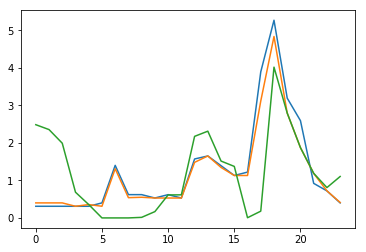

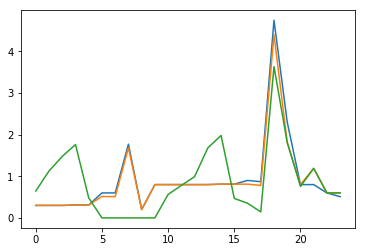

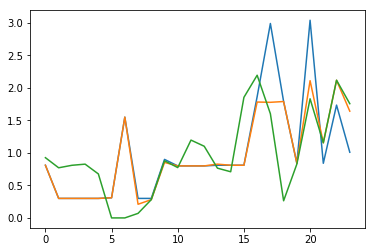

In [20]:
# residential
x1 = rh1_res
ref1 = np.dot(rh1_test.Ta, rh1_test.sche)
opt1 = np.dot(rh1_test.Ta, x1[:rh1_test.sp])
load1 = np.dot(rh1_test.Tx, x1)

x2 = rh2_res
ref2 = np.dot(rh2_test.Ta, rh2_test.sche)
opt2 = np.dot(rh2_test.Ta, x2[:rh2_test.sp])
load2 = np.dot(rh2_test.Tx, x2)

x3 = rh3_res
ref3 = np.dot(rh3_test.Ta, rh3_test.sche)
opt3 = np.dot(rh3_test.Ta, x3[:rh3_test.sp])
load3 = np.dot(rh3_test.Tx, x3)

plt.figure(0)
plt.plot(ref1)
plt.plot(opt1)
plt.plot(load1)

plt.figure(1)
plt.plot(ref2)
plt.plot(opt2)
plt.plot(load2)

plt.figure(2)
plt.plot(ref3)
plt.plot(opt3)
plt.plot(load3)

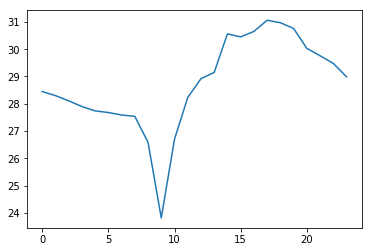

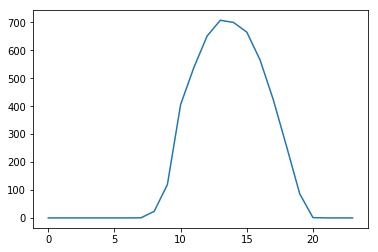

In [21]:
# weather
plt.figure(0)
plt.plot(AirTemp)

plt.figure(1)
plt.plot(Radiation)

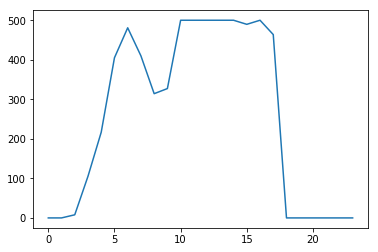

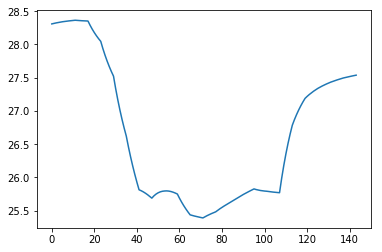

In [22]:
# commercial
Ud = np.kron(cb_res, np.ones(cb_test.mc))
RoomTemp = cb_test.bld.N_time_steps(cb_test.x0, Ud, cb_test.W)['T1']

plt.figure(0)
plt.plot(cb_res)

plt.figure(1)
plt.plot(RoomTemp)

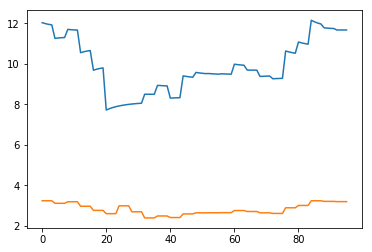

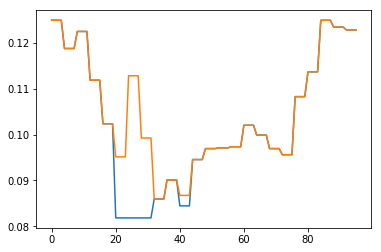

In [23]:
# industrial
Id = np.kron(ip_res[:ip_test.Nc], np.ones(ip_test.mc))
res_el = ip_test.el.N_time_steps(Id, ip_test.T0, ip_test.Ta)
conEl = res_el['P']/1000
genH2 = res_el['n']*3.6

Ig = np.kron(ip_res[ip_test.Nc:], np.ones(ip_test.mc))
res_fc = ip_test.fc.N_time_steps(Ig)
conH2 = res_fc['n']*3.6
genEl = res_fc['P']/1000

plt.figure(0)
plt.plot(conEl)
plt.plot(genEl)

plt.figure(1)
plt.plot(genH2)
plt.plot(conH2)

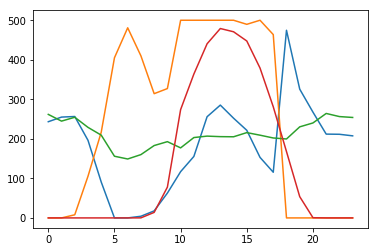

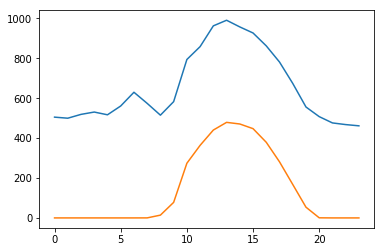

In [24]:
# system load
plt.figure(0)
plt.plot(l1+l2+l3)
plt.plot(l4)
plt.plot(l5)
plt.plot(totGen)

plt.figure(1)
plt.plot(l1+l2+l3+l4+l5)
plt.plot(totGen)

In [25]:
print('cost:', rh1_test.objfunction(rh1_res), 'load:', np.sum(l1), 'cost/load:', rh1_test.objfunction(rh1_res)/np.sum(l1))
print('cost:', rh2_test.objfunction(rh2_res), 'load:', np.sum(l2), 'cost/load:', rh2_test.objfunction(rh2_res)/np.sum(l2))
print('cost:', rh3_test.objfunction(rh3_res), 'load:', np.sum(l3), 'cost/load:', rh3_test.objfunction(rh3_res)/np.sum(l3))
print('cost:', cb_test.objfunction(cb_res), 'load:', np.sum(l4), 'cost/load:', cb_test.objfunction(cb_res)/np.sum(l4))
print('cost:', ip_test.objfunction(ip_res), 'load:', np.sum(l5), 'cost/load:', ip_test.objfunction(ip_res)/np.sum(l5))

cost: 303.92958550128367 load: 1716.388230057546 cost/load: 0.17707508137077688
cost: 223.46280195543548 load: 1262.1895995951572 cost/load: 0.17704376745546815
cost: 248.5237306396329 load: 1403.4833713446124 cost/load: 0.17707636279404854
cost: 1255.189886864885 load: 6220.795805200327 cost/load: 0.2017732017205256
cost: 705.4434939050408 load: 5111.1652803192665 cost/load: 0.1380200903737896
